In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
label_encoder = preprocessing.LabelEncoder()
from matplotlib import pyplot

teams_2021 = ["afghanistan","australia","bangladesh","england","india","ireland","namibia","netherlands","new zealand",\
             "oman","pakistan","papua new guinea","scotland","sri lanka","west indies"]

def get_matches_played(df, row, team):
    matches_played = df[((df.date < row.date))&((df.team1 == team)|(df.team2 == team))].shape[0]
    return matches_played if matches_played else 1

def get_matches_won(df, row, team):
    matches_won = df[((df.date < row.date))&(df.winner == team)].shape[0]
    return matches_won if matches_won else 0

def get_past_data(df, row, team, number):
    tempdf = df[((df.date < row.date))&((df.team1 == team)|(df.team2 == team))].tail(number)
    total = tempdf.shape[0]
    wins = tempdf[tempdf.winner == team].shape[0]
    return wins/total if total>=5 else np.nan

def deriving_features(df):
    #deriving new features below
    teams = {'t1':"team1",'t2':"team2"}
    for team in teams.keys():
        df['%s_matches_played'%team] = df.apply(lambda row: get_matches_played(df, row, row[teams[team]]), axis=1)
        df['%s_matches_won'%team] = df.apply(lambda row: get_matches_won(df, row, row[teams[team]]), axis=1)
        df['%s_matches_lost'%team] = df['%s_matches_played'%team] - df['%s_matches_won'%team]
        df['%s_win_per'%team] = df['%s_matches_won'%team]/df['%s_matches_played'%team]
        df['%s_odds_of_win'%team] = df['%s_matches_won'%team]/df['%s_matches_lost'%team]
        df['%s_win_prob'%team] = df['%s_odds_of_win'%team]/(1+df['%s_odds_of_win'%team]) #this is drived probability will be used in model training
        df['%s_past10_win_per'%team] = df.apply(lambda row: get_past_data(df, row, row[teams[team]],10),axis=1) #past performance
        df['%s_past10_lose_per'%team] = 1-df['%s_past10_win_per'%team]
    return df

In [4]:
Orgdf=pd.DataFrame()
for year in range(2005,2021+1,1):
    Orgdf = pd.concat([Orgdf,pd.read_csv(r"C:\Users\Alok\Downloads\dataset\cricket\T20_Data_%s.csv"%year)])   
    #Orgdf = pd.concat([Orgdf,pd.read_csv(r"C:\Users\Alok\Downloads\dataset\cricket\T20_Data_%s.csv"%year)])

#loading ipl data
#ipldf = pd.read_csv(r"C:\Users\Alok\Downloads\dataset\cricket\ipl_data.csv") #IPL data
ipldf = pd.read_csv(r"C:\Users\Alok\Downloads\dataset\cricket\ipl_data.csv") #IPL data

#concatinating both data
Orgdf = pd.concat([Orgdf,ipldf])

Orgdf.reset_index(drop=True)

# converting date into datetime format for dates comparison
Orgdf.date = pd.to_datetime(Orgdf.date)

Orgdf = Orgdf.sort_values(by='date')
#removing non-resulting matches, as non resulting match doesn't contribute much
Orgdf = Orgdf[Orgdf.winner != "draw"]

#converting "team" name into target variable which is team1 or team2
Orgdf['team'] = np.where(Orgdf.winner == Orgdf.team1, -1, 1)

In [5]:
# create mactches played column, winning percentages, losing percentages for both teams, last 10 matches (win,lose,win/lose) ratio
df = Orgdf.copy()
df = deriving_features(df)

#resetting index
df = df.reset_index(drop=True)

# making a copy to keep original data safe which will be used earlier
# missing value treatment
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0.0,inplace=True)

target = df.team.values
df = df.drop(['countries','result','winner','team1', 'team2'], axis = 1) #dropping team names

In [6]:
df.columns

Index(['date', 'team', 't1_matches_played', 't1_matches_won',
       't1_matches_lost', 't1_win_per', 't1_odds_of_win', 't1_win_prob',
       't1_past10_win_per', 't1_past10_lose_per', 't2_matches_played',
       't2_matches_won', 't2_matches_lost', 't2_win_per', 't2_odds_of_win',
       't2_win_prob', 't2_past10_win_per', 't2_past10_lose_per'],
      dtype='object')

In [7]:
#df = pd.get_dummies(df)

# df = df.drop(['date'], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.1, random_state = 17)

C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserW

Accuracy : 0.6132075471698113
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.641


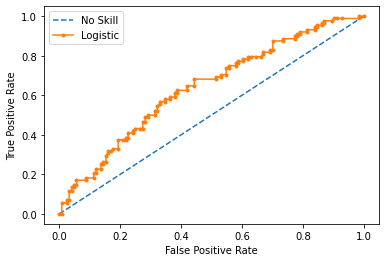

In [8]:
prop = int(df.shape[0]*0.1)
X_train = df.iloc[:-1*prop]
y_train = X_train['team'].values
X_train.drop(['date','team'],axis=1,inplace=True)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

select = SelectKBest(chi2, k=8)
X_train = select.fit_transform(X_train, y_train)
select.get_feature_names_out()

X_test = df.iloc[-1*prop:]
y_test = X_test['team'].values
X_test.drop(['date','team'],axis=1,inplace=True)
X_test = X_test[select.get_feature_names_out()]


####################################
######### Model Training ##########

#model = XGBClassifier()
model = LogisticRegression() # test size=0.2, derived variables, t20+ipl, auc roc = 64.5,accuracy = 62
#model = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=43)
#model = DecisionTreeClassifier(max_depth=20)
model.fit(X_train, y_train)
pred_result = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,pred_result).ravel()
print("Accuracy : %s"%((tn+tp)/(tn+tp+fn+fp)))

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
#pyplot.save()
pyplot.show()

In [62]:
new_df = pd.read_csv("C:/Users/Alok/Downloads/dataset/cricket/phase2.csv")
pred_df = new_df.copy()

def get_matches_played_pred(df, row, team):
    #print(df[((df.date < row.date))&((df.team1 == team)|(df.team2 == team))])
    matches_played = df[((df.date < row.date))&((df.team1 == team)|(df.team2 == team))].shape[0]
    return matches_played if matches_played else 1

def get_matches_won_pred(df, row, team):
    matches_won = df[((df.date < row.date))&(df.winner == team)].shape[0]
    return matches_won if matches_won else 0

def get_past_data_pred(df, row, team, number):
    tempdf = df[((df.date < row.date))&((df.team1 == team)|(df.team2 == team))].tail(number)
    total = tempdf.shape[0]
    wins = tempdf[tempdf.winner == team].shape[0]
    return wins/total if total>=5 else np.nan

def deriving_features_pred(df, pred_df):
    #deriving new features below
    teams = {'t1':"team1",'t2':"team2"}
    for team in teams.keys():
        pred_df['%s_matches_played'%team] = pred_df.apply(lambda row: 1+get_matches_played_pred(df, row, row[teams[team]]), axis=1)
        pred_df['%s_matches_won'%team] = pred_df.apply(lambda row: get_matches_won_pred(df, row, row[teams[team]]), axis=1)
        pred_df['%s_matches_lost'%team] = pred_df['%s_matches_played'%team] - pred_df['%s_matches_won'%team]
        pred_df['%s_win_per'%team] = pred_df['%s_matches_won'%team]/pred_df['%s_matches_played'%team]
        pred_df['%s_odds_of_win'%team] = pred_df['%s_matches_won'%team]/pred_df['%s_matches_lost'%team]
        pred_df['%s_win_prob'%team] = pred_df['%s_odds_of_win'%team]/(1+pred_df['%s_odds_of_win'%team]) #this is drived probability will be used in model training
        pred_df['%s_past10_win_per'%team] = pred_df.apply(lambda row: get_past_data(df, row, row[teams[team]],10),axis=1) #past performance
        pred_df['%s_past10_lose_per'%team] = 1-pred_df['%s_past10_win_per'%team]
    return pred_df

def prepare_predict_data(pred_df):
    pred_df.columns = list(map(lambda x: x.lower(), pred_df.columns))
    pred_df.match = pred_df.match.apply(str.lower)
    pred_df[['team1','team2']] = pred_df.match.str.split(" vs ",expand=True)
    pred_df.date = pd.to_datetime(pred_df.date)
    pred_df.drop(['match'],axis=1,inplace=True)
    return pred_df

In [63]:
pred_df = prepare_predict_data(pred_df)
pred_df = deriving_features_pred(Orgdf, pred_df)
pred_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pred_df.fillna(0.0,inplace=True)
#pred_df.drop(['date','team1','team2'], axis=1, inplace=True)
pred_df = pred_df[select.get_feature_names_out()]

new_df.columns = list(map(lambda x: x.lower(), new_df.columns))
new_df.match = new_df.match.apply(str.lower)
new_df[['team1','team2']] = new_df.match.str.split(" vs ",expand=True)
new_df['result'] = model.predict(pred_df)
new_df['pred_prob'] = model.predict_proba(pred_df)[:, 1]
new_df.pred_prob = np.where(new_df.pred_prob<=0.5,1-new_df.pred_prob,new_df.pred_prob)

new_df['winner'] = np.where(new_df.result == -1,new_df.team1,new_df.team2)
new_df.drop(['result'],axis=1,inplace=True)

group1 = ["england", "australia", "south africa", "west indies", "sri lanka", "bangladesh"]
group2 = ["india", "pakistan", "new zealand", "afghanistan", "namibia", "scotland"]

tempdf1 = new_df[new_df.team1.isin(group1)|new_df.team2.isin(group1)]
tempdf1['group'] = "group1"
tempdf2 = new_df[new_df.team1.isin(group2)|new_df.team2.isin(group2)]
tempdf2['group'] = "group2"

new_df = pd.concat([tempdf1,tempdf2])

C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Alok\AppData\Local\Temp/ipykernel_13796/1024524249.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf1['group'] = "group1"
C:\Users\Alok\AppData\Local\Temp/ipykernel_13796/1024524249.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [54]:
#new_df.to_csv("C:/Users/imall/Downloads/dataset/cricket/Pred_Circakathon_Zephyrus_16102021.csv")

In [69]:
new_df.groupby(['group',"winner"]).agg({'winner':'count'})

winner
group  winner              
group1 australia          3
       england            4
       south africa       5
       sri lanka          1
       west indies        2
group2 afghanistan        2
       india              4
       new zealand        3
       pakistan           5
       scotland           1

In [75]:
new_df = pd.read_csv("C:/Users/Alok/Downloads/dataset/log_semis.csv")
pred_df = new_df.copy()
pred_df = prepare_predict_data(pred_df)
pred_df = deriving_features_pred(Orgdf, pred_df)
pred_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pred_df.fillna(0.0,inplace=True)
#pred_df.drop(['date','team1','team2'], axis=1, inplace=True)
pred_df = pred_df[select.get_feature_names_out()]

new_df.columns = list(map(lambda x: x.lower(), new_df.columns))
new_df.match = new_df.match.apply(str.lower)
new_df[['team1','team2']] = new_df.match.str.split(" vs ",expand=True)
new_df['result'] = model.predict(pred_df)
new_df['pred_prob'] = model.predict_proba(pred_df)[:, 1]
new_df.pred_prob = np.where(new_df.pred_prob<=0.5,1-new_df.pred_prob,new_df.pred_prob)

new_df['winner'] = np.where(new_df.result == -1,new_df.team1,new_df.team2)
new_df.drop(['result'],axis=1,inplace=True)

# group1 = ["england", "australia", "south africa", "west indies", "sri lanka", "bangladesh"]
# group2 = ["india", "pakistan", "new zealand", "afghanistan", "namibia", "scotland"]

# tempdf1 = new_df[new_df.team1.isin(group1)|new_df.team2.isin(group1)]
# tempdf1['group'] = "group1"
# tempdf2 = new_df[new_df.team1.isin(group2)|new_df.team2.isin(group2)]
# tempdf2['group'] = "group2"

# new_df = pd.concat([tempdf1,tempdf2])

C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [76]:
new_df

,date,match,time,team1,team2,pred_prob,winner
0,10-11-2021,south africa vs india,7:30 PM,south africa,india,0.551210,india
1,11-11-2021,england vs pakistan,7:30 PM,england,pakistan,0.655665,pakistan


In [77]:
new_df = pd.read_csv("C:/Users/Alok/Downloads/dataset/final.csv")
pred_df = new_df.copy()
pred_df = prepare_predict_data(pred_df)
pred_df = deriving_features_pred(Orgdf, pred_df)
pred_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pred_df.fillna(0.0,inplace=True)
#pred_df.drop(['date','team1','team2'], axis=1, inplace=True)
pred_df = pred_df[select.get_feature_names_out()]

new_df.columns = list(map(lambda x: x.lower(), new_df.columns))
new_df.match = new_df.match.apply(str.lower)
new_df[['team1','team2']] = new_df.match.str.split(" vs ",expand=True)
new_df['result'] = model.predict(pred_df)
new_df['pred_prob'] = model.predict_proba(pred_df)[:, 1]
new_df.pred_prob = np.where(new_df.pred_prob<=0.5,1-new_df.pred_prob,new_df.pred_prob)

new_df['winner'] = np.where(new_df.result == -1,new_df.team1,new_df.team2)
new_df.drop(['result'],axis=1,inplace=True)

# group1 = ["england", "australia", "south africa", "west indies", "sri lanka", "bangladesh"]
# group2 = ["india", "pakistan", "new zealand", "afghanistan", "namibia", "scotland"]

# tempdf1 = new_df[new_df.team1.isin(group1)|new_df.team2.isin(group1)]
# tempdf1['group'] = "group1"
# tempdf2 = new_df[new_df.team1.isin(group2)|new_df.team2.isin(group2)]
# tempdf2['group'] = "group2"

# new_df = pd.concat([tempdf1,tempdf2])

C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Alok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [78]:
new_df

,date,match,time,team1,team2,pred_prob,winner
0,14-11-2021,india vs pakistan,7:30 PM,india,pakistan,0.58752,pakistan
